In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def format(mirror: str) -> int:

    m, n = mirror[:2], int(mirror[2:])

    if m == 'll': n+= 0
    if m == 'lm': n+= 7
    if m == 'la': n+= 14
    if m == 'co': n+= 21
    if m == 'he': n+= 28

    return n

/tmp/ipykernel_8581/1209150880.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False,
/tmp/ipykernel_8581/1209150880.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(cal_xy_corr / cal_std, positions=[format(run['telescope'].strip())], vert=False,
/tmp/ipykernel_8581/1209150880.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False,
/tmp/ipykernel_8581/1209150880.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() 

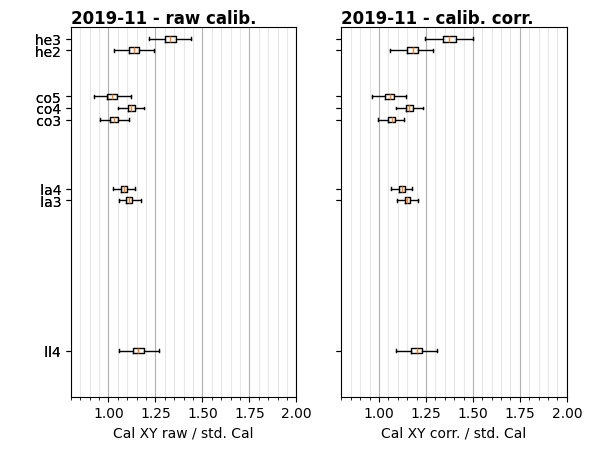

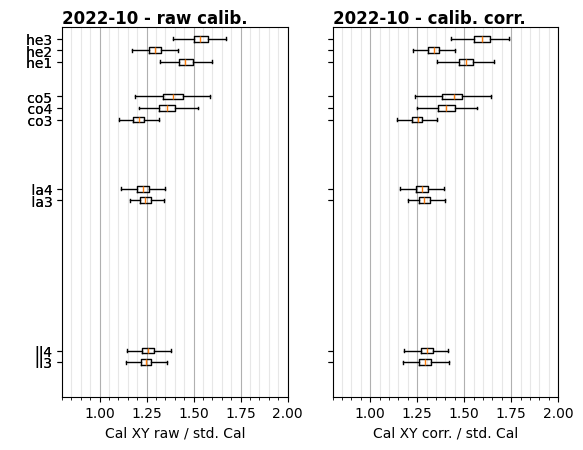

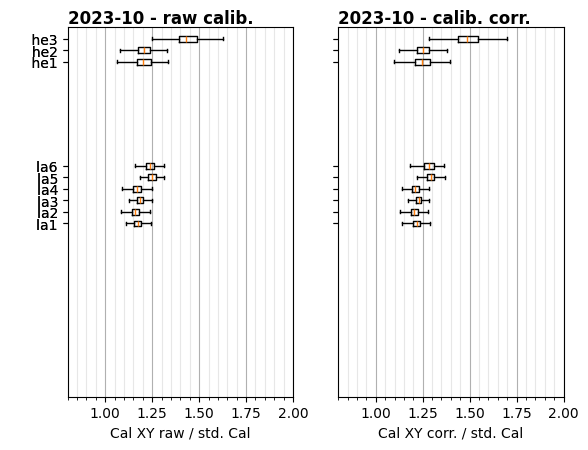

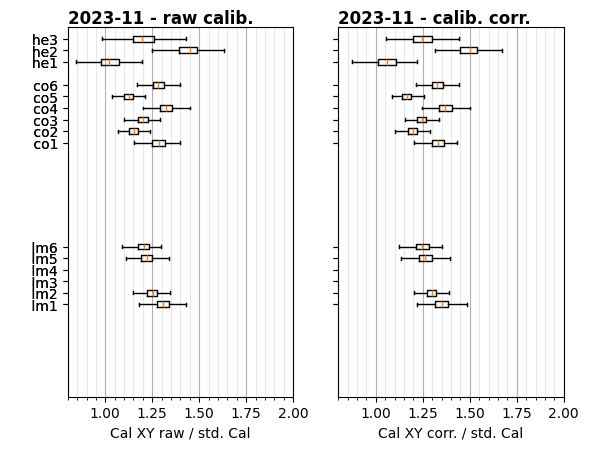

In [4]:
runlist_dir = '/home/filip/xy-calibration/config/calib_runlists/'
source_dir = '/home/filip/xy-calibration/results/'

reject = ['15952x',     # co2 due to ??? (ASK!!!!!!!!!!)
          '15920x',     # co5 due to curtain in aperture
          '6075',       # he2 due to cold electronics
          ]

# fig, axes = plt.subplots(4, 1, sharex=True)

axes = [plt.subplots(1, 2, sharey=True)[1] for _ in range(4)]

for (ax1, ax2), list in zip(axes, ['2019-11', '2022-10', '2023-10', '2023-11']):

    ax1.set_xticks(np.arange(0.8, 2.0, 0.05), minor=True)   # set minor ticks on x-axis
    ax2.set_xticks(np.arange(0.8, 2.0, 0.05), minor=True)   # set minor ticks on x-axis

    ax1.text(0, 1, f"{list} - raw calib.", transform=ax1.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax2.text(0, 1, f"{list} - calib. corr.", transform=ax2.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax1.set_xlabel(r"Cal XY raw / std. Cal")
    ax2.set_xlabel(r"Cal XY corr. / std. Cal")
    ax1.set_xlim(0.8, 2.0)
    ax2.set_xlim(0.8, 2.0)
    ax1.set_ylim(0, 32)
    ax1.grid(axis='x')
    ax2.grid(axis='x')
    ax1.grid(axis='x', which='minor', alpha=0.3)
    ax2.grid(axis='x', which='minor', alpha=0.3)

    with open(f'{runlist_dir}calib_runs_{list}.list', 'r') as f:
        header = f.readline().strip().split(';')

    df = pd.read_csv(f'{runlist_dir}/calib_runs_{list}.list',
                     comment='#', delimiter=';', names=header)
    
    for i, run in df.iterrows():
        if run['#runid'].strip() in reject: continue
        if not run['forDB']: continue
        if not run['source'].strip() in ['"OLO"', "OLO"]: continue
        if not run['comment'].strip() != '': continue

        try:
            # pixel calibConst adcSum stdCalib calibConstCorr
            cal_xy, cal_std, cal_xy_corr = np.loadtxt(f'{source_dir}/outCorr_{run["#runid"]}.txt', usecols=[1, 3, 4], unpack=True)
            ax1.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False, 
                       labels=[run['telescope']], showfliers=False, widths=0.5)
            ax2.boxplot(cal_xy_corr / cal_std, positions=[format(run['telescope'].strip())], vert=False, 
                       labels=[run['telescope']], showfliers=False, widths=0.5)

        except FileNotFoundError: continue

    plt.subplots_adjust(hspace=-0.3)
    # raise StopIteration

In [3]:
print(np.mean(cal_xy_corr / cal_xy), np.std(cal_xy_corr / cal_xy))

1.0360041503030593 0.008820566213408133
